1.このSprintについて

Sprintの目的
セグメンテーションの精度を向上させる

どのように学ぶか
Kaggleコンペティションの情報を参考にセグメンテーションの精度を向上させます。



2.セグメンテーションの精度向上

前回に引き続きTGS Salt Identification Challengのデータセットの学習・推定を行います。


TGS Salt Identification Challenge | Kaggle


3.事前準備
このSprintでは、以下のバージョンを使用します。

TensorFrow: 1.14.0
Keras: 2.3.1

ResNetとVGGの課題用コードにアクセスし、パスワード入力欄に1963を入力します。
アクセス先からMEF_sprint20_03_models_pretrained_and_more.ipynbをダウンロードしてください。
ダウンロードしたファイルをGoogle Colabの「ファイルを開く」からアップロードすることで、ファイルの中身を閲覧できます。

【問題1】コードレビュー
事前準備でダウンロードしたコードは、転移学習を使用してセグメンテーションの精度を改善したコードです。
このコードについて、レビューを行ってください。


《視点例》


前回使用した実装とはどのように違うのか
転移学習をどのように行っているか


In [13]:
#前回使用した実装とはどのように違うのか
# ResNetのスキップコネクションと、U-NetのContracting Pathの発想はほとんど同じで、
# 大きな違いはEncoderとDecoderの間に張るということだけです。
# ResNetはDecoderのないシンプルなCNNですが、レイヤーの間にこのような配線（スキップコネクション）
# を追加することで、勾配消失に強いという特徴があり
# U-Netが一般的なAEと大きく異なる点2は、EncoderとDecoderの間にはしごのように配線があるということです。
# 残差ブロックでは、畳込み層とSkip Connectionの組み合わせになっている。2つの枝から構成されていて、
# それぞれの要素を足し合わせる。残差ブロックの一つはConvolution層の組み合わせで、もう一つはIdentity関数となる。
# こうすれば、仮に追加の層で変換が不要でもweightを0にすれば良い。
# 残差ブロックを導入することで、結果的に層の深度の限界を押し上げることができ、精度向上を果たすことが出来た。

#転移学習をどのように行っているか
# 残差ブロックでは、畳込み層とSkip Connectionの組み合わせになっている。
# 2つの枝から構成されていて、それぞれの要素を足し合わせる。
# 残差ブロックの一つはConvolution層の組み合わせで、もう一つはIdentity関数となる。
# こうすれば、仮に追加の層で変換が不要でもweightを0にすれば良い。
# 残差ブロックを導入することで、結果的に層の深度の限界を押し上げることができ、精度向上を果たすことが出来た。

【問題2】コードの書き換え
エンコーダーにResNetが使用されていたコードをVGGに変更してください。

【問題3】学習・推定
ResNetとVGG双方のコードで学習・推定を行い、結果を比較してください。

In [14]:
pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.2
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.0.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl

In [15]:
!pip install keras==2.2.0
!pip install tensorflow==1.15
!pip install Keras-Applications==1.0.7

  Using cached Keras_Preprocessing-1.0.1-py2.py3-none-any.whl (26 kB)
  Using cached Keras_Applications-1.0.2-py2.py3-none-any.whl (43 kB)
  Attempting uninstall: keras-preprocessing
    Found existing installation: Keras-Preprocessing 1.1.2
    Uninstalling Keras-Preprocessing-1.1.2:
      Successfully uninstalled Keras-Preprocessing-1.1.2
  Attempting uninstall: keras-applications
    Found existing installation: Keras-Applications 1.0.7
    Uninstalling Keras-Applications-1.0.7:
      Successfully uninstalled Keras-Applications-1.0.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 1.15.0 requires keras-applications>=1.0.8, but you have keras-applications 1.0.2 which is incompatible.
tensorflow 1.15.0 requires keras-preprocessing>=1.0.5, but you have keras-preprocessing 1.0.1 which is incompatible.
kapre 0.3.5 requires tensorflow>=2.0.0, but you ha

  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Attempting uninstall: keras-preprocessing
    Found existing installation: Keras-Preprocessing 1.0.1
    Uninstalling Keras-Preprocessing-1.0.1:
      Successfully uninstalled Keras-Preprocessing-1.0.1
  Attempting uninstall: keras-applications
    Found existing installation: Keras-Applications 1.0.2
    Uninstalling Keras-Applications-1.0.2:
      Successfully uninstalled Keras-Applications-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras 2.2.0 requires keras-applications==1.0.2, but you have keras-applications 1.0.8 which is incompatible.
keras 2.2.0 requires keras-preprocessing==1.0.1, but you have keras-preprocessing 1.1.2 which is incompatible.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.

  Using cached Keras_Applications-1.0.7-py2.py3-none-any.whl (51 kB)
  Attempting uninstall: Keras-Applications
    Found existing installation: Keras-Applications 1.0.8
    Uninstalling Keras-Applications-1.0.8:
      Successfully uninstalled Keras-Applications-1.0.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 1.15.0 requires keras-applications>=1.0.8, but you have keras-applications 1.0.7 which is incompatible.
keras 2.2.0 requires keras-applications==1.0.2, but you have keras-applications 1.0.7 which is incompatible.
keras 2.2.0 requires keras-preprocessing==1.0.1, but you have keras-preprocessing 1.1.2 which is incompatible.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.15.0 which is incompatible.


In [16]:
#ResNet

import gc
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input

%matplotlib inline

In [17]:
pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.2
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.0.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl

In [18]:
plt.rcParams['figure.figsize'] = (12, 9)
# plt.style.use('ggplot')

In [19]:
def compute_coverage(df, masks):
    
    df = df.copy()
    
    def cov_to_class(val):
        for i in range(0, 11):
            if val * 10 <= i:
                return i

    # Output percentage of area covered by class
    df['coverage'] = np.mean(masks, axis=(1, 2))
    # Coverage must be split into bins, otherwise stratified split will not be possible,
    # because each coverage will occur only once.
    df['coverage_class'] = df.coverage.map(
        cov_to_class)

    return df


def create_depth_abs_channels(image_tensor):
    image_tensor = image_tensor.astype(np.float32)
    h, w, c = image_tensor.shape
    for row, const in enumerate(np.linspace(0, 1, h)):
        image_tensor[row, :, 1] = const
    image_tensor[:, :, 2] = (
        image_tensor[:, :, 0] * image_tensor[:, :, 1])

    x_dx = np.diff(image_tensor[:, :, 0], axis=0)
    x_dy = np.diff(image_tensor[:, :, 0], axis=1)
    x_dx = cv2.copyMakeBorder(x_dx, 1, 0, 0, 0, cv2.BORDER_CONSTANT, 0)
    x_dy = cv2.copyMakeBorder(x_dy, 0, 0, 1, 0, cv2.BORDER_CONSTANT, 0)
    image_tensor[:, :, 1] = np.abs(x_dx + x_dy)

    return image_tensor

In [20]:
# train = pd.read_csv('../input/train.csv')
# test = pd.read_csv('../input/sample_submission.csv')
# depth = pd.read_csv('../input/depths.csv')
# path = '/content/drive/MyDrive/DIC/ResNet_VGG'

train = pd.read_csv('/content/drive/MyDrive/DIC/ResNet_VGG/input/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DIC/ResNet_VGG/input/sample_submission.csv')
depth = pd.read_csv('/content/drive/MyDrive/DIC/ResNet_VGG/input/depths.csv')

#train_src = '../input/train/'
train_src = '/content/drive/MyDrive/DIC/ResNet_VGG/input/train/'

print('train:\n{}'.format(train.head()))
print('\ntest:\n{}'.format(test.head()))


train = train.merge(depth, how='left', on='id')
test = test.merge(depth, how='left', on='id')

print('\n{}'.format(train.head()))

train:
           id                                           rle_mask
0  2c45b152f1  99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...
1  3cb59a4fdc                                             1 5656
2  e185ab5dc1  4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...
3  c78c89577c                                              101 1
4  6306dd3a8e  1 30 102 29 203 29 304 28 405 27 506 27 607 26...

test:
           id rle_mask
0  3e06571ef3      1 1
1  a51b08d882      1 1
2  c32590b06f      1 1
3  15f7a047c7      1 1
4  e8827bc832      1 1

           id                                           rle_mask    z
0  2c45b152f1  99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...  312
1  3cb59a4fdc                                             1 5656  603
2  e185ab5dc1  4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...  687
3  c78c89577c                                              101 1  236
4  6306dd3a8e  1 30 102 29 203 29 304 28 405 27 506 27 607 26...  805


In [21]:
# X_train = np.asarray(
#     # [cv2.imread('../input/train/images/{}.png'.format(x), 0) for x in train.id.tolist()], 
#     [cv2.imread('/content/drive/MyDrive/DIC/ResNet_VGG/input/train/images/{}.png'.format(x), 0) for x in train.id.tolist()], 
#     dtype=np.uint8) / 255.
# y_train = np.asarray(
#     #[cv2.imread('../input/train/masks/{}.png'.format(x), 0) for x in train.id.tolist()],
#     [cv2.imread('/content/drive/MyDrive/DIC/ResNet_VGG/input/train/masks/{}.png'.format(x), 0) for x in train.id.tolist()],
#     dtype=np.uint8) / 255.

# print(X_train.shape, y_train.shape)

In [22]:
# # 画像のロードにかなりの時間がかかるので、読込済みのデータを保存しておく。
# import pickle
# with open('/content/drive/My Drive/DIC/ResNet_VGG/X_train.pkl', 'wb') as xtrain:
#     pickle.dump(X_train, xtrain)

# with open('/content/drive/My Drive/DIC/ResNet_VGG/y_train.pkl', 'wb') as ytrain:
#     pickle.dump(y_train, ytrain)

In [23]:
import pickle
# with open('school.binaryfile', 'rb') as web:
#   techacademy = pickle.load(web)
#   print techacademy

with open('/content/drive/My Drive/DIC/ResNet_VGG/X_train.pkl', 'rb') as xtrain:
  X_train= pickle.load(xtrain)
  print("hogeX")
  print(hogeX)

with open('/content/drive/My Drive/DIC/ResNet_VGG/y_train.pkl', 'rb') as ytrain:
  y_train = pickle.load(ytrain)
  print("y_train")
  print(y_train)

hogeX
[[[0.34117647 0.35686275 0.37254902 ... 0.34901961 0.34117647 0.3372549 ]
  [0.34901961 0.37254902 0.39607843 ... 0.34901961 0.34901961 0.34509804]
  [0.37647059 0.39607843 0.41176471 ... 0.34901961 0.35686275 0.34901961]
  ...
  [0.16470588 0.14117647 0.14117647 ... 0.4        0.40784314 0.41176471]
  [0.18823529 0.17254902 0.18431373 ... 0.40392157 0.41176471 0.42352941]
  [0.20392157 0.19607843 0.20392157 ... 0.40784314 0.41176471 0.42745098]]

 [[0.45098039 0.54117647 0.58823529 ... 0.54901961 0.56078431 0.63137255]
  [0.47843137 0.54509804 0.60392157 ... 0.47058824 0.48627451 0.58431373]
  [0.49019608 0.5372549  0.62745098 ... 0.43921569 0.45098039 0.56470588]
  ...
  [0.77647059 0.69803922 0.45098039 ... 0.4745098  0.52156863 0.52156863]
  [0.70196078 0.65490196 0.45882353 ... 0.44313725 0.49019608 0.49411765]
  [0.63137255 0.6        0.4627451  ... 0.42745098 0.4745098  0.48235294]]

 [[0.46666667 0.50588235 0.54117647 ... 0.46666667 0.45882353 0.45490196]
  [0.54901961 0.

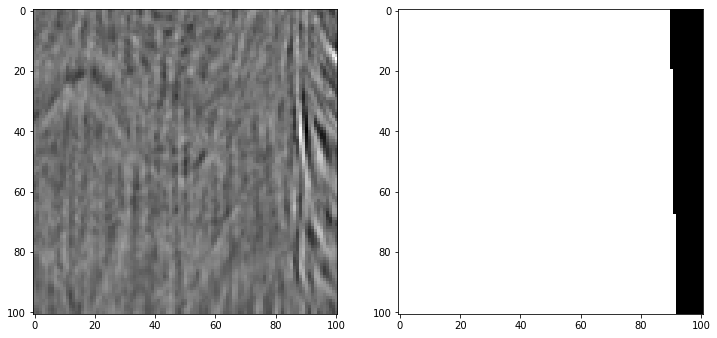

In [24]:
random_index = np.random.randint(0, X_train.shape[0])

fig, ax = plt.subplots(1, 2)

ax[0].imshow(X_train[random_index], cmap='gray')
ax[1].imshow(y_train[random_index], cmap='gray')

In [25]:
#Compute salt coverage (this will serve as a basis for stratified split):
train = compute_coverage(train, y_train)

In [26]:
#Prepare data for training:
kfold = StratifiedKFold(n_splits=5, random_state=1337)

# Add channel features
X_train_ch = np.repeat(np.expand_dims(X_train, axis=-1), 3, -1)
X_train_ch = np.asarray(list(map(lambda x: create_depth_abs_channels(x), X_train_ch)))

# Resize to 224x224, default ResNet50 image size
X_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), X_train_ch)))
y_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), y_train)))


for train_index, valid_index in kfold.split(train.id.values, train.coverage_class.values):
    
    X_tr, X_val = X_resized[train_index], X_resized[valid_index]
    y_tr, y_val = y_resized[train_index], y_resized[valid_index]
    
    break
    

y_tr = np.expand_dims(y_tr, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)


del X_train_ch, y_resized
del X_resized
gc.collect()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


(3200, 224, 224, 3) (3200, 224, 224, 1)
(800, 224, 224, 3) (800, 224, 224, 1)


56

In [27]:
#Loss functions & metric:
from keras.losses import binary_crossentropy


# Dice & combined
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))



# Lovash loss: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss


# IoU metric for observation during training
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)


# For Lovash loss
def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

Encoder features - ResNet50:
In ResNet50, each block finishes with a pooling layer, so we can extract features from intermediate layers just before the pooling. This way, when first layer is added as additional extractor, we will have features extracted from 5 layers. Default input size will be assumed, which is (224, 224, 3). Layers will be as follows:

'activation_1', shape: (None, 112, 112, 64)
'activation_10', shape: (None, 56, 56, 256)
'activation_22', shape: (None, 28, 28, 512)
'activation_40', shape: (None, 14, 14, 1024)
'activation_49', shape: (None, 7, 7, 2048)
One thing to keep in mind is that every time a model will be created in the same TF session in the notebook, layer names will change, so above layer names correspond to first creation of the model. In order to reset session, call K.clear_session().

In [28]:
from keras import applications
input_size = (224, 224, 3)

base_model = ResNet50(input_shape=input_size, include_top=False)
base_model.summary()

/usr/local/lib/python3.7/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________

In [3]:
#VGGを試用したコード
from keras import applications
from tensorflow.keras.applications.vgg16 import VGG16
input_size = (224, 224, 3)

base_model2 = VGG16(input_shape=input_size, include_top=False)
base_model2.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________